In [1]:
from os.path import expanduser
import sys
motornet_home = expanduser("~") + "/MotorNet"
sys.path.append(motornet_home)

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import motornet as mn

# Disable all GPUS
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'
from motornet.plants.muscles import RigidTendonHillMuscleThelen

%load_ext autoreload
%autoreload 2

In [3]:
# SET UP PLANT, NETWORK, TASK
plant = mn.plants.RigidTendonArm26(muscle_type=RigidTendonHillMuscleThelen(), visual_delay=0.07, proprioceptive_delay=0.02)

n_units = 100
network = mn.nets.layers.GRUNetwork(plant=plant, n_units=n_units, kernel_regularizer=1e-7, name='network', recurrent_regularizer=1e-5)

start_joint_position = [0.873, 1.745] # [50,100] deg
go_cue_range=[.100, .400]
task = mn.tasks.CentreOutReach(network=network, start_joint_position=start_joint_position, go_cue_range=go_cue_range)
rnn = tf.keras.layers.RNN(cell=network, return_sequences=True, name='RNN')

input_dict = task.get_input_dict_layers()
state0 = task.get_initial_state_layers()
states_out = rnn(input_dict, initial_state=state0)

nn = mn.nets.MotorNetModel(inputs=[input_dict, state0], outputs=states_out, name='model', task=task)
nn.compile(optimizer=tf.optimizers.Adam(clipnorm=1.), loss=task.losses, loss_weights=task.loss_weights)

2022-03-13 15:34:51.635962: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
task.get_losses()

[{'joint position': None,
  'cartesian position': <motornet.nets.losses.PositionLoss at 0x7f8e32d7e4c0>,
  'muscle state': <motornet.nets.losses.L2xDxActivationLoss at 0x7f8e32d7e490>,
  'geometry state': None,
  'proprioceptive feedback': None,
  'visual feedback': None,
  'gru_hidden0': <motornet.nets.losses.L2xDxRegularizer at 0x7f8e32d7e520>},
 {'joint position': 0.0,
  'cartesian position': 1.0,
  'muscle state': 5,
  'geometry state': 0.0,
  'proprioceptive feedback': 0.0,
  'visual feedback': 0.0,
  'gru_hidden0': 0.1}]

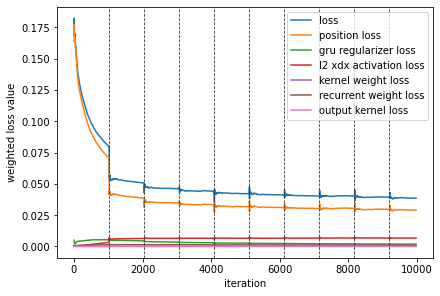

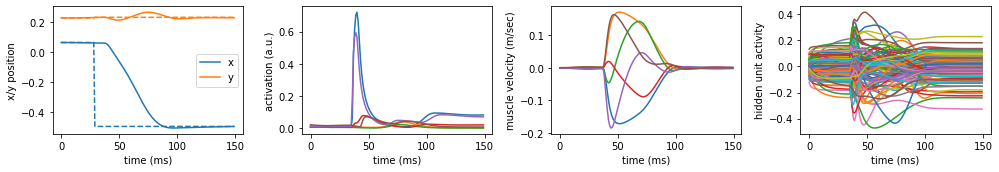

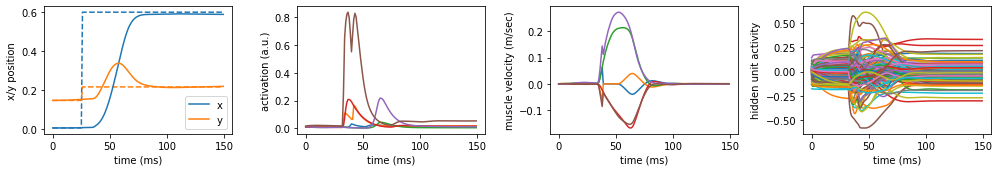

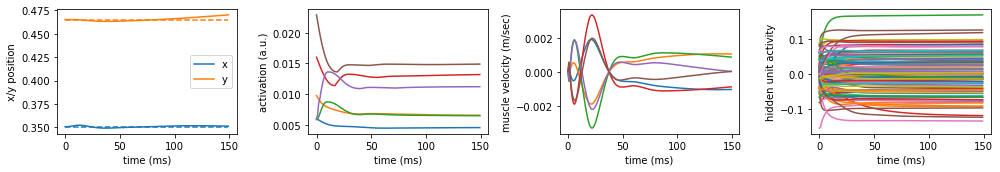

1024/1024 [==============================] - 164s 157ms/step - loss: 0.0385 - position_loss: 0.0289 - gru_regularizer_loss: 0.0178 - l2_xdx_activation_loss: 0.0013


In [5]:
# TRAIN THE NETWORK
n_t = 150
n_batches = 2**10
batch_size = 2**6
# this callback logs training information for each batch passed, rather than for each epoch.
callbacks = [mn.nets.callbacks.BatchLogger(), mn.nets.callbacks.TrainingPlotter(task,plot_freq=256,plot_trials=3,plot_n_t=n_t)]
for i in range(10):
    [inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=n_batches * batch_size)
    h = nn.fit(x=[inputs, init_states], y=targets, verbose=1, epochs=1, batch_size=batch_size, shuffle=False, callbacks=callbacks)

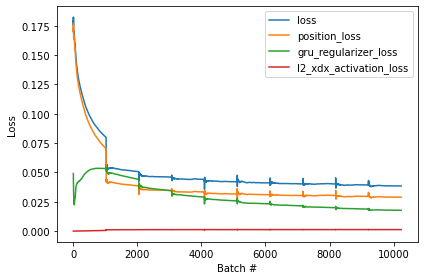

In [6]:
# PLOT LOSS FUNCTIONS OVER TRAINING
# Not normalized to weight for each loss
def print_training_log(log):
    plt.figure().set_tight_layout(True)
    for kk, vv in log.items():
        plt.plot(vv, label=kk)
    plt.ylabel("Loss")
    plt.xlabel("Batch #")
    plt.legend()
    plt.show()

training_log = callbacks[0].history
print_training_log(log=training_log)

In [7]:
# TEST THE NETWORK ON THE CENTRE-OUT REACHING TASK
task.angle_step = 45
[inputs, targets, init_states] = task.generate(n_timesteps=n_t, batch_size=1, validation=True)
results = nn([inputs, init_states], training=False)

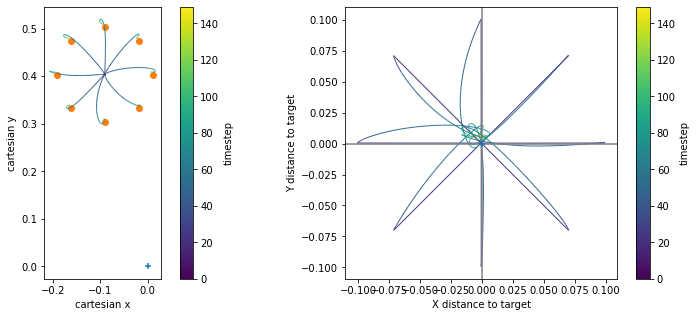

In [8]:
plotor = mn.utils.plotor.plot_pos_over_time
def plot_simulations(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure(figsize=(15,5))

  plt.subplot(1,2,1)
  plotor(xy)
  plt.scatter(target_x, target_y)

  plt.subplot(1,2,2)
  plotor(xy - target_xy)
  plt.axhline(0, c="grey")
  plt.axvline(0, c="grey")
  plt.xlabel("X distance to target")
  plt.ylabel("Y distance to target")
  plt.show()

plot_simulations(xy=results["cartesian position"], target_xy=targets)

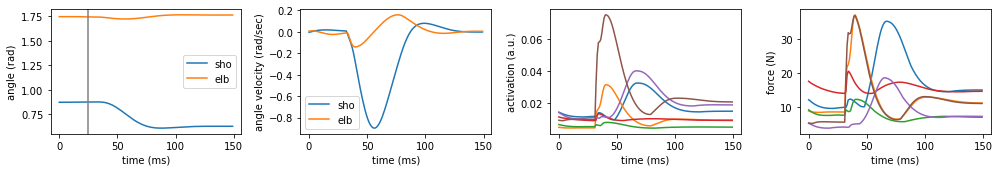

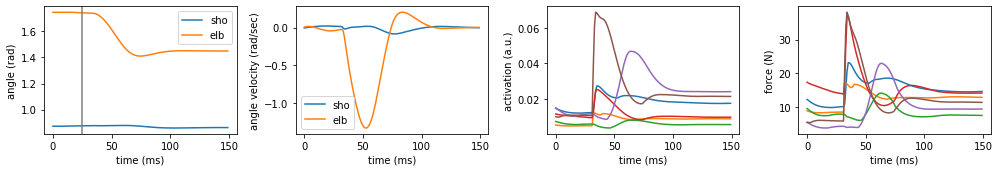

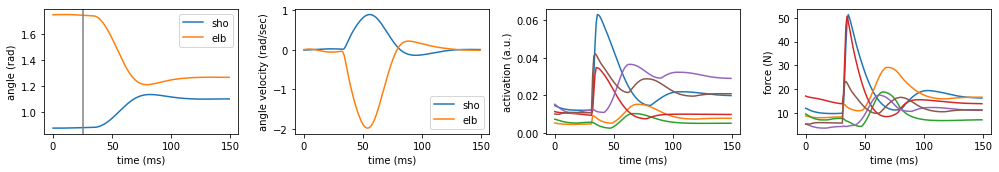

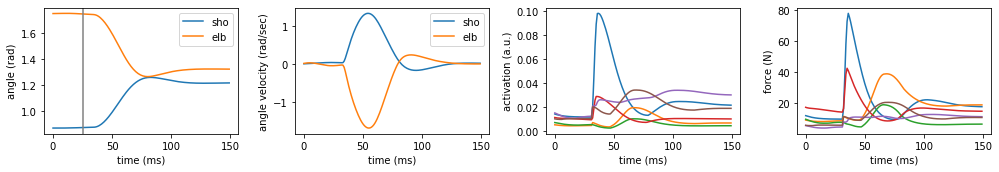

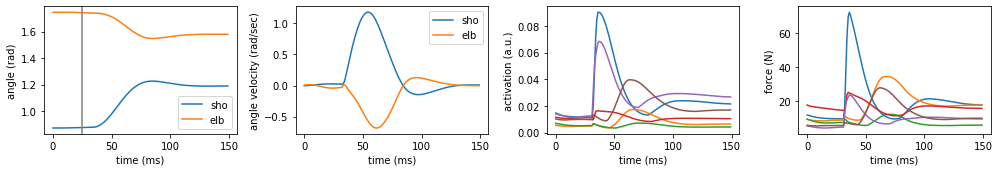

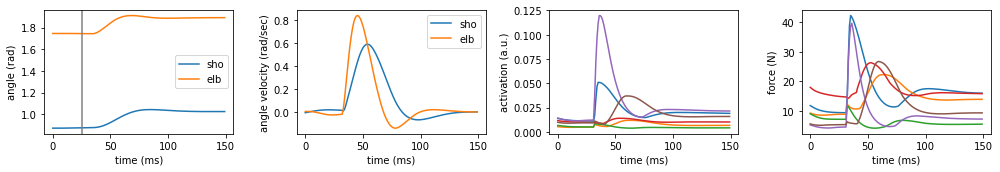

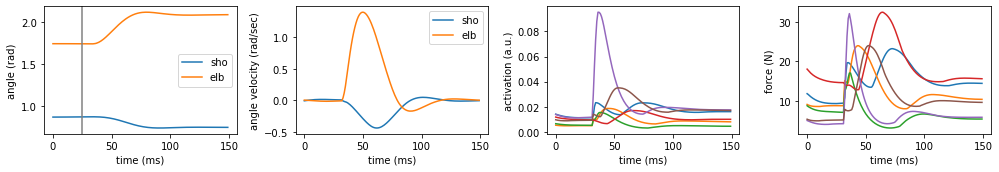

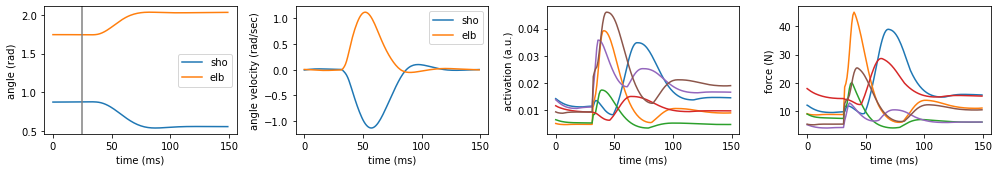

In [9]:
def plot1trial(inputs, results, trial=0):
    j_results = results['joint position']
    m_results = results['muscle state']

    plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

    plt.subplot(141)
    plt.plot(j_results[trial, :, 0], label='sho')
    plt.plot(j_results[trial, :, 1], label='elb')
    plt.axvline(np.where(inputs["inputs"][trial, :, -1] != 1)[0][0] - network.visual_delay, c='grey')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle (rad)')

    plt.subplot(142)
    plt.plot(j_results[trial, :, 2], label='sho')
    plt.plot(j_results[trial, :, 3], label='elb')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle velocity (rad/sec)')

    plt.subplot(143)
    plt.plot(m_results[trial, :, 0, :])
    plt.xlabel('time (ms)')
    plt.ylabel('activation (a.u.)')

    plt.subplot(144)
    plt.plot(m_results[trial, :, -1, :])
    plt.xlabel('time (ms)')
    plt.ylabel('force (N)')

    plt.show()

for i in range(int(360/task.angle_step)):
    plot1trial(inputs, results, i)